In [1]:
from torch_geometric.data import Data, InMemoryDataset
import numpy as np
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import matplotlib.pyplot as plt
import scipy.special as SS
import scipy.stats as SSA
import pandas as pd
import copy

In [2]:
R0_ts = pd.read_csv('../df_EpiEstim_R_median.csv',index_col='Date')
R0_ts.fillna(0, inplace=True)
pop_sorted = np.loadtxt('../pop_sorted.csv')
N = pop_sorted.shape[0]
file_path = '/Users/qingyao/Documents/branching_data/real_data/' ##M_202003_10.csv

In [3]:
## load all the mobility matrix

In [4]:
T = 60

In [5]:
### parameter parts ###
r = 0.1
P_ts = pd.DataFrame()
P_ts.index = R0_ts.index
df_to_add = R0_ts[R0_ts.columns.values].apply(lambda x: r/(x+r))
P_ts = pd.concat([P_ts, df_to_add], axis=1)
P_ts_s = P_ts.iloc[22:100,:]
P_ts_s = P_ts_s.reset_index().rename(columns={'index': 'Date'})

In [6]:
dates_list = pd.date_range('2020-02-21',periods=T).strftime('%Y-%m-%d').values 

In [ ]:
### if i set the threshold to 100!

In [ ]:
M_peop = np.zeros((T,N,N))
for ti in range(T):
    print('the current simulating time', ti)
#     p_ti = P_ts.iloc[ti].values[1:]
#     date_parts = P_ts_s.iloc[ti]['Date'].split('-')
    date_parts = dates_list[ti].split('-')
    y, m, d = date_parts
#         WN = np.load(file_path+'M_{}{}_{}.csv')
    ################# Mobility#######################
    M_test = np.loadtxt(
        file_path+'M_{}{}_{}.csv'.format(y, m, d), delimiter=',')
    M_peop[ti,:,:] = M_test

In [ ]:
WN = np.zeros((T,N,N))
for ti in range(T):
    M_test = M_peop[ti] 
    th = 10
#     for i in range(N):
#         M_i = M_test[:,i] 
#         M_test[M_i < th,i] = 0 ## travel out <100 then set all the travelling to zero
#     M_pop = M_test/pop_sorted[None, :]
#     # if there is no one go out from one site
#     temp = np.sum(M_pop, axis=0)
#     if np.sum(temp == 0) == 0:
#         M_pop_norm = M_pop/temp[None, :]
#     else:
#         #             print('there is no one go out from one site')
#         mask = temp == 0
#         temp[mask] = 1
#         M_pop_norm = M_pop/temp[None, :]
#         M_pop_norm[:, mask] = 0
#         M_pop_norm[mask, mask] = 1
# #         WN_small = M_pop_norm[:100,:100]
#     WN[ti,:,:] = M_pop_norm  # WN_small/np.sum(WN_small,axis=0)[None,:]

### x should be today's infected
### y should be tomorrow's infected

In [9]:
real_data_path = '/Users/qingyao/OneDrive - cumc.columbia.edu/machine_learning_data/'
cases = pd.read_csv(real_data_path + 'county_data/ts_covid19_confirmed_US_mainland.csv')
cases_sorted = cases.sort_values(by='UID').reset_index(drop=True)

In [10]:
dates_col = cases.columns[40:12+344] ## starting with 2020-02-21
formatted_dates = [pd.to_datetime(date).strftime('%Y-%m-%d') for date in dates_col]
s_cases = pd.DataFrame(index=range(3108), columns = formatted_dates[1:])
daily_cases = np.diff(np.array(cases_sorted[dates_col]),axis=1)
daily_cases[daily_cases<0] = 0
s_cases.iloc[:,:] = daily_cases 

In [3]:
### do it for everyday

In [15]:
neigh_list = []
neighbours_len_list = []
for t in range(T-1):   
    print('t:', t)
    A = M_peop[t]
    ## only the neighbours of NYC
    g_m = nx.from_numpy_array(A)
    g_m.remove_edges_from(nx.selfloop_edges(g_m))
    neighbours = list(g_m.neighbors(1824))
    print('number_neighbours:', len(neighbours))
    neighbours_len_list.append(len(neighbours))
    neigh_list.extend(neighbours)

t: 0
number_neighbours: 1328
t: 1
number_neighbours: 1327
t: 2
number_neighbours: 1325
t: 3
number_neighbours: 1282
t: 4
number_neighbours: 1282
t: 5
number_neighbours: 1279
t: 6
number_neighbours: 1281
t: 7
number_neighbours: 1282
t: 8
number_neighbours: 1279
t: 9
number_neighbours: 1277
t: 10
number_neighbours: 1480
t: 11
number_neighbours: 1482
t: 12
number_neighbours: 1481
t: 13
number_neighbours: 1484
t: 14
number_neighbours: 1483
t: 15
number_neighbours: 1483
t: 16
number_neighbours: 1476
t: 17
number_neighbours: 1343
t: 18
number_neighbours: 1344
t: 19
number_neighbours: 1342
t: 20
number_neighbours: 1341
t: 21
number_neighbours: 1341
t: 22
number_neighbours: 1339
t: 23
number_neighbours: 1339
t: 24
number_neighbours: 871
t: 25
number_neighbours: 871
t: 26
number_neighbours: 867
t: 27
number_neighbours: 866
t: 28
number_neighbours: 862
t: 29
number_neighbours: 856
t: 30
number_neighbours: 852
t: 31
number_neighbours: 738
t: 32
number_neighbours: 735
t: 33
number_neighbours: 739


Text(0.5, 0, 'T')

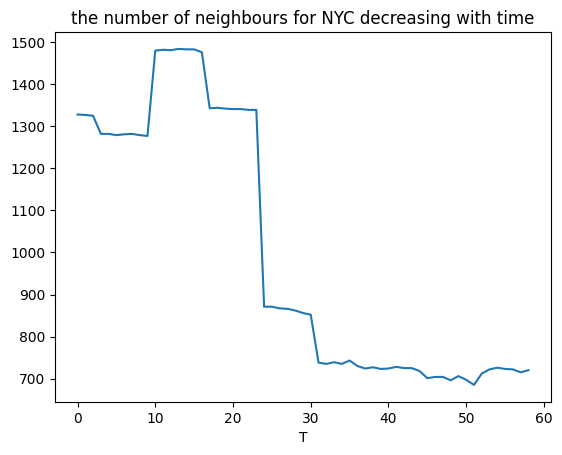

In [21]:
plt.plot(range(59),neighbours_len_list)
plt.title('the number of neighbours for NYC decreasing with time')
plt.xlabel('T')

In [16]:
n_all_time = list(set(neigh_list))
n_all_time.sort()

In [17]:
len(n_all_time)

2138

In [46]:
data_list = []
for t in range(T-1):
    col_date_x = dates_list[t]
    col_date_y = dates_list[t+1]
    x = s_cases.iloc[n_all_time][col_date_x].astype(float).values
    y = s_cases.iloc[n_all_time][col_date_y].astype(float).values
    A = WN[t]
    G = nx.from_numpy_array(A)
    G_sub = G.subgraph(n_all_time)
    A_sub = nx.adjacency_matrix(G_sub).toarray()
    adjacency_matrix = torch.tensor(A_sub)
    edge_index = torch.nonzero(adjacency_matrix, as_tuple=False).t()
    edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]
    data_i = Data(x=torch.tensor(x), edge_index=edge_index, edge_attr=edge_weight, y = torch.tensor(y))
    data_list.append(data_i)

In [49]:
mydataset = dataset.collate(data_list)